In [1]:
from lib.HK.header_notebook import *
import lib.HK.OTCommon as OTCommon
import lib.HK.SinkhornNP as Sinkhorn
import lib.HK.LinHK as LinHK
import lib.HK.LinW2 as LinW2
import lib.HK.Tools as Tools
from scipy import sparse

import torch
import numpy as np 
import os
import sys
import numba as nb
import matplotlib.pyplot as plt
import time
from sklearn.datasets import make_swiss_roll, make_moons, make_circles
import ot
import csv

os.chdir('/home/baly/projects/linear_opt')

from lib.lib_lopt import *
from lib.geodesic import *
from lib.tools import *

/tmp/ipykernel_2011255/2816020232.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_list=np.asarray(X_list)
/tmp/ipykernel_2011255/2816020232.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  p_list=np.asarray(p_list)


0
0.75
1.2
save data


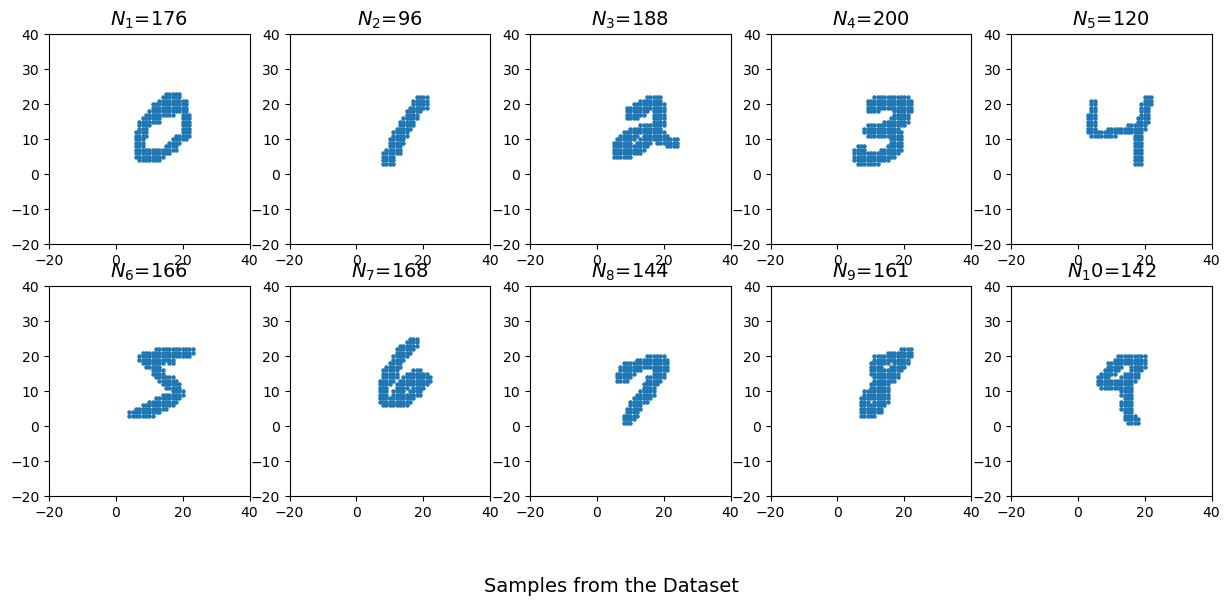

done


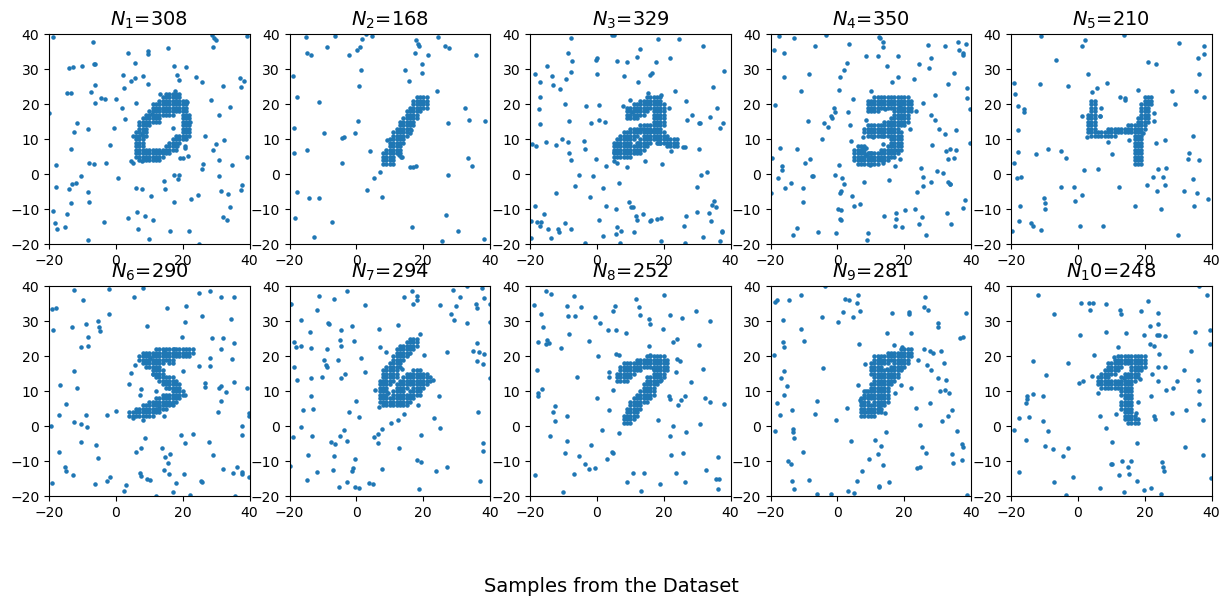

done


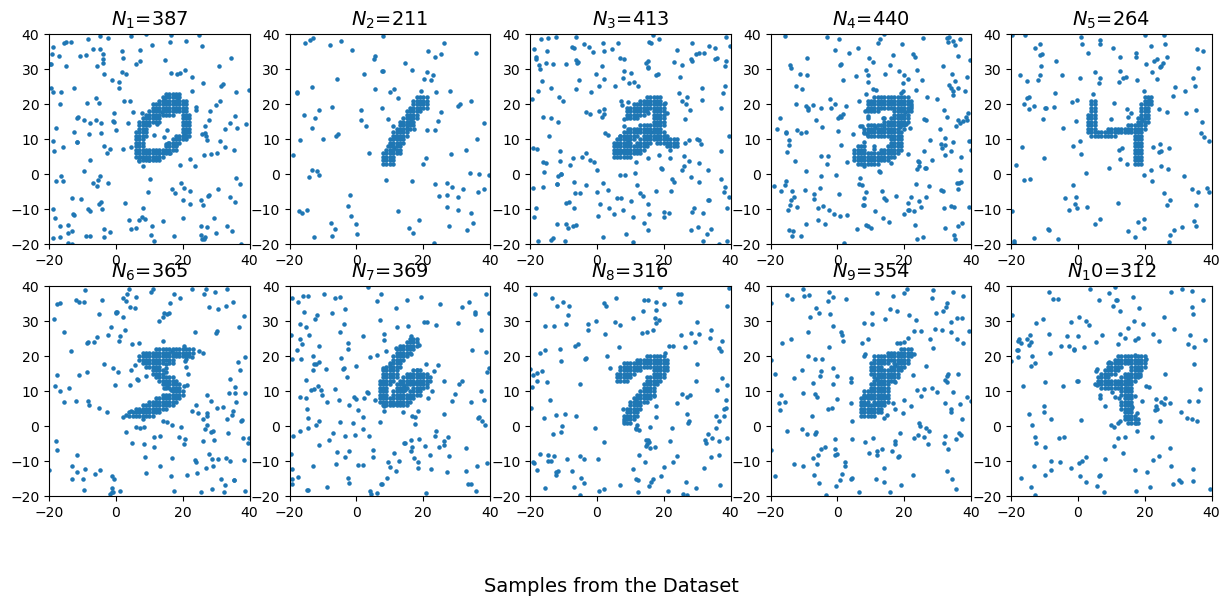

done


In [30]:
# load data, and add noise 

data0=torch.load('experiment/data/MNIST/pca.pt')

data_list={}
data_list['0']=data0
per1=0.75
per2=1.20

X0_list,p0_list,label_list=data0
label_list=np.array(label_list)
for per in [0,per1,per2]:
    X_list=list()
    p_list=list()
    for i,(Xi,pi,label) in enumerate(zip(X0_list,p0_list,label_list)):
        N,d=Xi.shape
        n_noise=int(per*N)
        noise_i=np.random.uniform(low=[-20,-20],high=[40,40],size=(n_noise,d))
        noise_pi=np.ones(n_noise)/n_noise*per
        Xi_noise=np.concatenate((Xi,noise_i))
        pi_noise=np.concatenate((pi,noise_pi))
        X_list.append(Xi_noise)
        p_list.append(pi_noise)
    X_list=np.asarray(X_list)
    p_list=np.asarray(p_list)
    data_list[str(per)]=(X_list,p_list,label_list)
torch.save(data_list,'experiment/data/MNIST/pca_noise.pt')

for key in data_list:
    print(key)
print('save data')

for per in [0,per1,per2]:
    k=5
    X_list,p_list,label_list=data_list[str(per)]
    fig,ax=plt.subplots(2,5,figsize=(3*5,3*2))
    ind=0
    for i in range(10):
        X=X_list[i*300]
        ax[int(i/5),i%5].scatter(X[:,0],X[:,1],s=5)
        ax[int(i/5),i%5].set_title(r'$N_%d$=%d'%(i+1,X.shape[0]),fontsize=14)
        ax[int(i/5),i%5].set_xlim(-20,40)
        ax[int(i/5),i%5].set_ylim(-20,40)
    fig.text(0.5, -0.05, 'Samples from the Dataset', ha='center',fontsize=14)
    plt.show()
    print('done')

    

In [31]:
# choose 3 labels and save the data 
label_select=[0,1,3]
data_list=torch.load('experiment/data/MNIST/pca_noise.pt')
MNIST_select_noise={}
for per in [0,per1,per2]:
    X_list,p_list,label_list=data_list[str(per)]
    index_list=np.concatenate([np.arange(300*i,300*(i+1)) for i in label_select])
    MNIST_select_noise[str(per)]=(X_list[index_list],p_list[index_list],label_list[index_list])
torch.save(MNIST_select_noise,'experiment/data/MNIST/pca_noise_select.pt')
label_list1=label_list[index_list]

# Pick arbitrary data and compute the barycenter

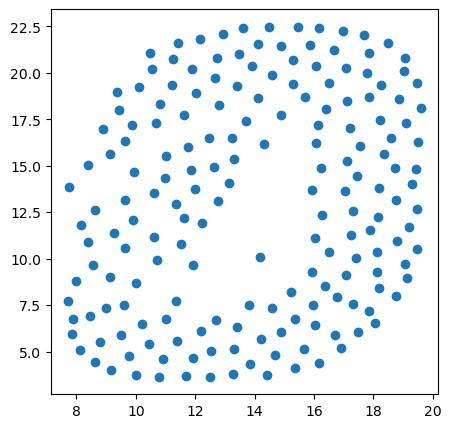

1.0


In [32]:
label_select=[0,1,3]
data_list=torch.load('experiment/data/MNIST/pca_noise_select.pt')

# computer barycenter 
N=10
N0=300
X_list,p_list,label_list=data_list['0']
sample_list=sampling(X_list,N,N0,len(label_select))
N_list=np.zeros(len(sample_list),dtype=np.int64)
for i in range(len(sample_list)):
    N_list[i]=sample_list[i].shape[0]
N0=int(np.mean(N_list))+30
p0=np.ones(N0)/N0


p_list=[]
for i in range(len(sample_list)):
    p_list.append(np.ones(N_list[i])/N_list[i])

X0_init=np.random.uniform([5,5],[25,25],(N0,2))
weights=np.ones(len(sample_list))/len(sample_list)
X0=lot_barycenter(sample_list,p_list,X0_init,p0,weights)

fig,ax=plt.subplots(1,1,figsize=(5,5))
plt.scatter(X0[:,0],X0[:,1])
plt.show()
print(p0.sum())



# compute the OT embedding

In [55]:
# get lot embedding: 
time_start=time.time()
data_list=torch.load('experiment/data/MNIST/pca_noise_select.pt')
lot_embed={}
lot_embed['X0']=X0
lot_embed['p0']=p0
for per in [0,per1,per2]:
    X_list,p_list,label_list=data_list[str(per)]
    U_list=list() #np.zeros((len(X_list),p0.shape[0],2))
    for i, (Xi,pi) in enumerate(zip(X_list,p_list)): 
        pi=pi/np.sum(pi)
        Ui=lot_embedding(X0,Xi,p0,pi)
        
        U_list.append(Ui) 
    U_list=np.array(U_list)
    lot_embed[str(per)+'_U_list']=U_list
time_end=time.time()
wall_time=time_end-time_start
print('LOT embedding requires %0.2f seconds'%wall_time)
torch.save(lot_embed,'experiment/pca/result/lot_embed.pt')


LOT embedding requires 96.17 seconds


# compute the OPT embedding

In [56]:
# get lopt embedding: 
time_start=time.time()
data_list=torch.load('experiment/data/MNIST/pca_noise_select.pt')
lopt_embed={}
lopt_embed['X0']=X0
lopt_embed['p0']=p0
Lambda=20.0
for per in [0,per1,per2]:
    X_list,p_list,label_list=data_list[str(per)]
    U_list=list()
    p_hat_list=list()
    for i, (Xi,pi) in enumerate(zip(X_list,p_list)):
        Ui,pi_hat,Mi,pi_perp=lopt_embedding(X0,Xi,p0,pi,Lambda)
        U_list.append(Ui)
        p_hat_list.append(pi_hat)
    U_list=np.array(U_list)
    p_hat_list=np.array(p_hat_list)
    lopt_embed[str(per)+'_U_list']=(U_list,p_hat_list)
time_end=time.time()
wall_time=time_end-time_start
print('LOpT embedding requires %0.2f seconds'%wall_time)

torch.save(lopt_embed,'experiment/pca/result/lopt_embed.pt')

LOpT embedding requires 75.94 seconds


# compute the HK embedding

In [57]:
time_start=time.time()
setup_HKScale=5.0
                           
# Do LHK embedding
params={}
params["setup_HKMode"]=True
params["setup_HKScale"]=setup_HKScale
params["solver_errorGoal"]=1e-4
params["aux_verbose"]=False
params["solver_epsStart"]=1e3*setup_HKScale/1.3 
params["solver_epsTarget"]=0.1*setup_HKScale/1.3 

# get lopt embedding: 
data_list=torch.load('experiment/data/MNIST/pca_noise_select.pt')
lhk_embed={}
lhk_embed['X0']=X0
lhk_embed['p0']=p0
Lambda=30.0
for per in [0,per1,per2]:
    X_list,p_list,label_list=data_list[str(per)]
    U_list=list()
    alpha0_list=list()
    for i, (Xi,pi) in enumerate(zip(X_list,p_list)):
        value,gamma=Sinkhorn.SolveHK(p0,X0,pi,Xi,HKScale=params["setup_HKScale"],
        SinkhornError=params["solver_errorGoal"],
        epsTarget=params["solver_epsTarget"], epsInit=params["solver_epsStart"],
        returnSolver=False)
        # from optimal coupling compute tangent vector data
        u0,u1,x1,muPerp,nuPerp=LinHK.extractMongeData(gamma,p0,pi,Xi)
        v0,alpha0=LinHK.HKLog(X0,u0,x1,u1,params["setup_HKScale"])
        U_list.append(v0)
        alpha0_list.append(alpha0)
    U_list=np.array(U_list)
    alpha0_list=np.array(alpha0_list)
    lhk_embed[str(per)+'_U_list']=(U_list,alpha0_list)
time_end=time.time()
wall_time=time_end-time_start
print('LHK embedding requires %0.2f seconds'%wall_time)
torch.save(lhk_embed,'experiment/pca/result/lhk_embed.pt')
print('done')

LHK embedding requires 327.15 seconds
done


# Do PCA analysis for LOPT embedding

In [58]:
# test LOT
lot_embed=torch.load('experiment/pca/result/lot_embed.pt')
X0=lot_embed['X0']
p0=lot_embed['p0']
k=2
pca_lot={}
for per in [0,per1,per2]:
    U_list=lot_embed[str(per)+'_U_list']
    a,eig,V=PCA_numpy(U_list,k)
    pca_lot[str(per)]=(a,eig,V)
torch.save(pca_lot,'experiment/pca/result/pca_lot.pt')


In [59]:
# test LOPT
lopt_embed=torch.load('experiment/pca/result/lopt_embed.pt')
X0=lopt_embed['X0']
p0=lopt_embed['p0']
k=2
pca_lopt={}
for per in [0,per1,per2]:
    U_list,_=lopt_embed[str(per)+'_U_list']
    a,eig,V=PCA_numpy(U_list,k)
    pca_lopt[str(per)]=(a,eig,V)
torch.save(pca_lopt,'experiment/pca/result/pca_lopt.pt')



In [60]:
# test LHK
lopt_embed=torch.load('experiment/pca/result/lhk_embed.pt')
X0=lopt_embed['X0']
p0=lopt_embed['p0']
k=2
pca_lopt={}
for per in [0,per1,per2]:
    U_list,_=lopt_embed[str(per)+'_U_list']
    a,eig,V=PCA_numpy(U_list,k)
    pca_lopt[str(per)]=(a,eig,V)
torch.save(pca_lopt,'experiment/pca/result/pca_lhk.pt')

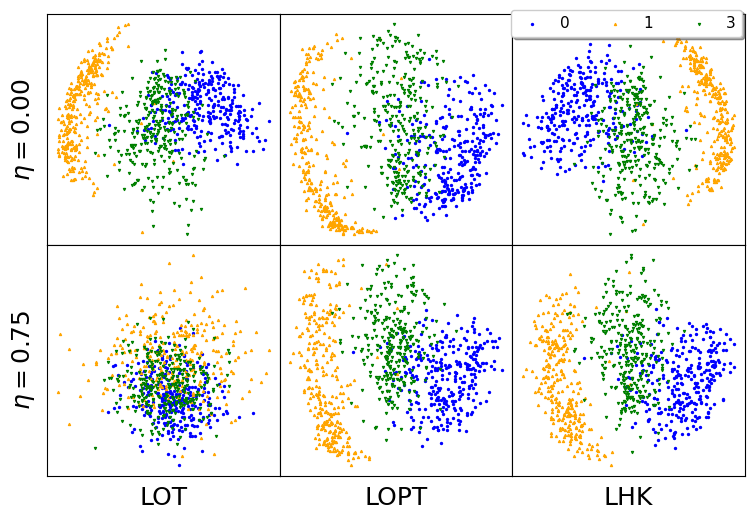

In [62]:
# plot the result
pt=0.001
color_list=['blue','orange','green']
method_list=['lot','lopt','lhk']
marker_list=['o','^','v']
fig,ax=plt.subplots(2,3,figsize=(3*3,2*3))
for (i,per) in enumerate([0,per1]):
    name='experiment/pca/result/pca_result.pdf'
    for j,method in enumerate(method_list):
        result=torch.load('experiment/pca/result/pca_'+method+'.pt')
        a,eig,V=result[str(per)]
        for (k,(color,marker)) in enumerate(zip(color_list,marker_list)):
            label=str(label_select[k])
            scatter_2d_sub(ax[i,j],a[300*(k):300*(k+1)],pt,xlim=None,ylim=None,color=color,marker=marker,label=label)
        if i==1:
            ax[i,j].set_xlabel(method.upper(),fontsize=18)
        if j==0:
            ax[i,j].set_ylabel(r'$\eta=%0.2f$'%(per),fontsize=18)
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        
    plt.subplots_adjust(wspace=0, hspace=0)
    ax[0,2].legend(bbox_to_anchor=(1.02, 1.05),loc='upper right',fancybox=True, shadow=True, ncol=3,fontsize=11)
    
    #ax[1].legend(fancybox=True, shadow=True, ncol=2,fontsize=8)
plt.savefig(name,dpi=200,format='pdf',bbox_inches='tight')
    
plt.show()

    